# MovieLens 10M

Detection results using different classifiers

**Parameters**

* d = 30% 
* θ = 0.75
* N = 6
* J = 40
* k = 30

Nota: los ejes están limitados de tamaño para poder comparar mejor, en la memoria irán de 0-1

Nota 2: He usado también la curva precisión - recall porque la AUC para imbalanced puede no ser significante

In [1]:
import sys
import os
from copy import deepcopy

import pandas as pd
import numpy as np

from sklearn.metrics import recall_score, precision_score, auc, roc_curve, roc_auc_score, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

import matplotlib.pyplot as plt

# Changing paths to src and importing co-forest
src_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(src_path)
from models.classifiers.CoForestClassifier import CoForest
from models.classifiers.TriTrainingClassifier import TriTraining

In [2]:
rd = np.random.RandomState(5)
J = 40

attributes_names = ["a{}".format(i) for i in range(1, 2*J + 1)]
attributes_names.append("tag")

In [3]:
df_train = pd.read_csv(filepath_or_buffer="./results-3/tr/train-all.csv", names=attributes_names)

X = df_train[df_train.columns[:-1]].values
y = df_train.tag.values.astype(int)

U_train, L_train, Uy_train, Ly_train = train_test_split(X, y, test_size=0.3, random_state=rd, shuffle=True, stratify=y)

In [4]:
# Random Forest
random_forest_all = RandomForestClassifier(6, max_features='log2', random_state=rd)
random_forest_all.fit(X, y)

# Random Forest - d (30%)
random_forest_d = RandomForestClassifier(6, max_features='log2', random_state=rd)
random_forest_d.fit(L_train, Ly_train)

# Co Forest
co_forest = CoForest(6, 0.75, max_features='log2', random_state=rd)
co_forest.fit(L_train, Ly_train, U_train)

# Tri Training
h_0 = DecisionTreeClassifier()
h_1 = GaussianNB()
h_2 = KNeighborsClassifier()
tri_training = TriTraining(h_0, h_1, h_2, random_state=rd)
tri_training.fit(L_train, Ly_train, U_train)

In [5]:
cls = [random_forest_all, random_forest_d, co_forest, tri_training]
cls_names= ["RF-A", "RF-L", "SADR-CoF", "TT"]

attack_size = [10, 20, 50, 100]
attack_size_tags = ['1%', '2%', '5%', '10%']

filler_size = [0.01, 0.03, 0.05, 0.1]
filler_size_tags = ['1%', '3%', '5%', '10%']

In [6]:
def get_comparation_graph(attack, y_low_lim=0, curve='ROC'):

    fig, axes = plt.subplots(3, 4, figsize=(12, 6), tight_layout=True)

    for j in range(4): # J = filler size

        recalls = {cls_name: [] for cls_name in cls_names} 
        precisions = {cls_name: [] for cls_name in cls_names} 
        AUCs = {cls_name: [] for cls_name in cls_names} 

        for e in range(1, 11): # e = nº experimentos (10 veces)

            df_genuine_test = pd.read_csv(filepath_or_buffer="./results-3/t-{}/test-{}-genuine.csv".format(e, e), names=attributes_names)
            recalls_experiment = {cls_name: [] for cls_name in cls_names} 
            precisions_experiment = {cls_name: [] for cls_name in cls_names} 
            AUCs_experiment = {cls_name: [] for cls_name in cls_names} 

            for k in range(4):  # K = attack size

                target = pd.read_csv(filepath_or_buffer="./results-3/t-{}/test-{}-{}-{}-{}.csv".format(e, e, attack, filler_size[j], attack_size[k]), names=attributes_names)
                vertical_stack = pd.concat([deepcopy(df_genuine_test), target], axis=0)
                X_test = vertical_stack[vertical_stack.columns[:-1]].values
                y_test  = vertical_stack.tag.values.astype(int)

                for cl, cls_name in zip(cls, cls_names):
                    y_pred = cl.predict(X_test)
                    recalls_experiment[cls_name].append(recall_score(y_test, y_pred))
                    precisions_experiment[cls_name].append(precision_score(y_test, y_pred))

                    if curve == 'ROC':
                        fpr, tpr, _ = roc_curve(y_test, cl.predict_proba(X_test)[:,1])
                        AUCs_experiment[cls_name].append(auc(fpr, tpr))
                    
                    else:
                        precision, recall, _ = precision_recall_curve(y_test, cl.predict_proba(X_test)[:,1])
                        AUCs_experiment[cls_name].append(auc(recall, precision))

            for cls_name in cls_names:
                recalls[cls_name].append(recalls_experiment[cls_name])
                precisions[cls_name].append(precisions_experiment[cls_name])
                AUCs[cls_name].append(AUCs_experiment[cls_name])


        axes[0][j].set_xlabel('Attack Size \n Filler size = {}'.format(filler_size_tags[j]))
        axes[0][j].set_ylabel('Recall')
        axes[0][j].set_ylim(y_low_lim, 1.1)

        axes[1][j].set_xlabel('Attack Size \n Filler size = {}'.format(filler_size_tags[j]))
        axes[1][j].set_ylabel('Precision')
        axes[1][j].set_ylim(y_low_lim, 1.1)

        axes[2][j].set_xlabel('Attack Size \n Filler size = {}'.format(filler_size_tags[j]))
        axes[2][j].set_ylabel('AUC')
        axes[2][j].set_ylim(y_low_lim, 1.1)

        for cls_name, style in zip (cls_names, ['->m', '-.^c', ':*k', '-og']):
            axes[0][j].plot(attack_size_tags, np.mean(np.array(recalls[cls_name]), axis=0), style, linewidth=0.8, label=cls_name)
            axes[1][j].plot(attack_size_tags, np.mean(np.array(precisions[cls_name]), axis=0), style, linewidth=0.8, label=cls_name)
            axes[2][j].plot(attack_size_tags, np.mean(np.array(AUCs[cls_name]), axis=0), style, linewidth=0.8, label=cls_name)

    handles, labels = axes[0][0].get_legend_handles_labels()
    fig.legend(handles, labels, bbox_to_anchor=(0.5, 1.05), loc='upper center', ncol=len(cls_names)) 
    plt.plot()

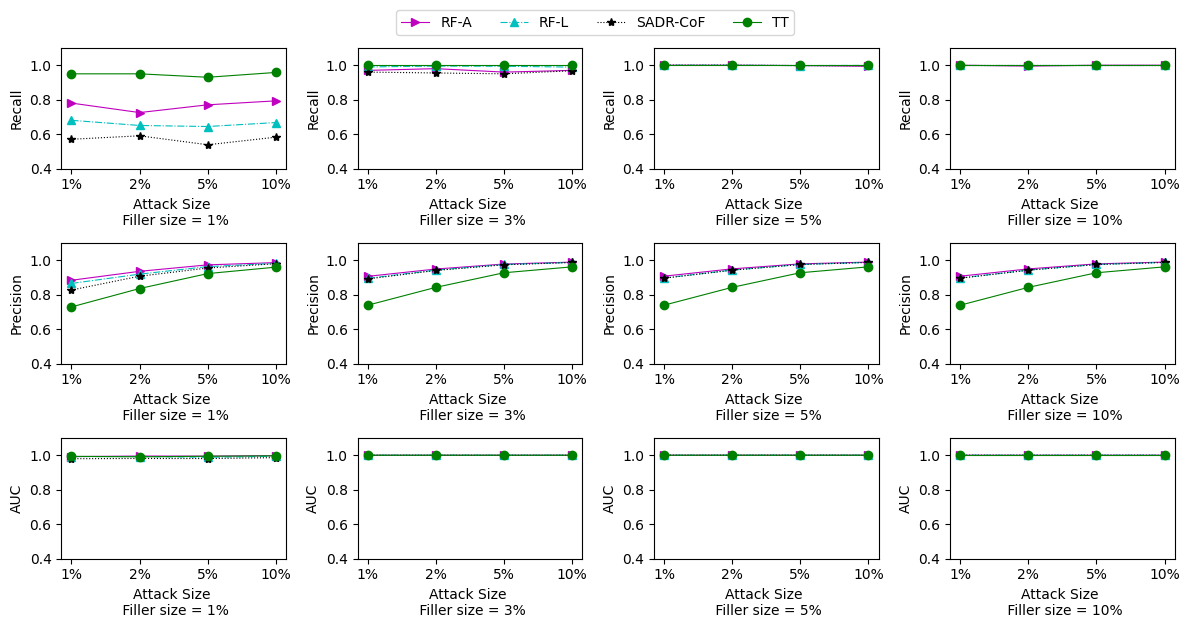

In [7]:
get_comparation_graph('random', 0.4)

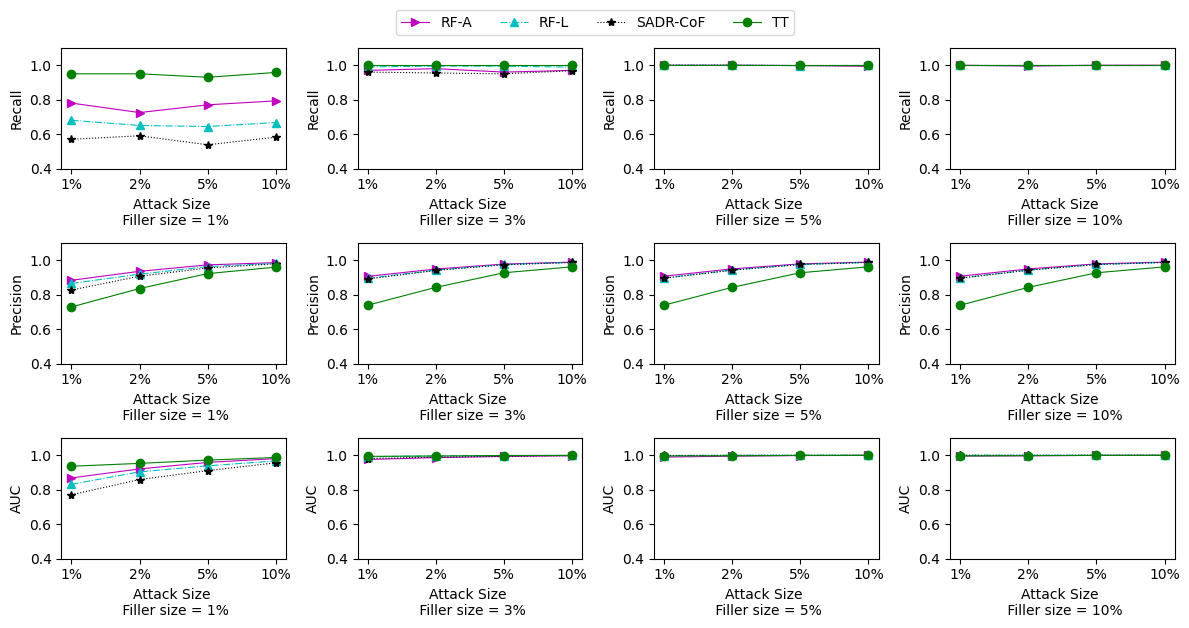

In [8]:
get_comparation_graph('random', 0.4, curve='PR')

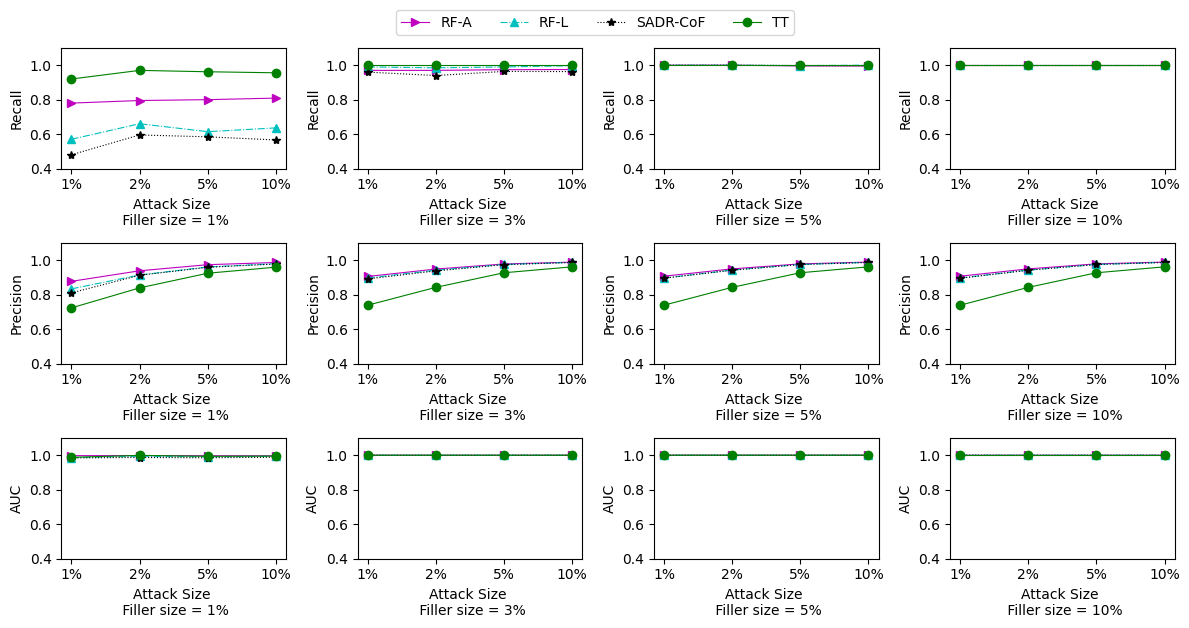

In [9]:
get_comparation_graph('average', 0.4)

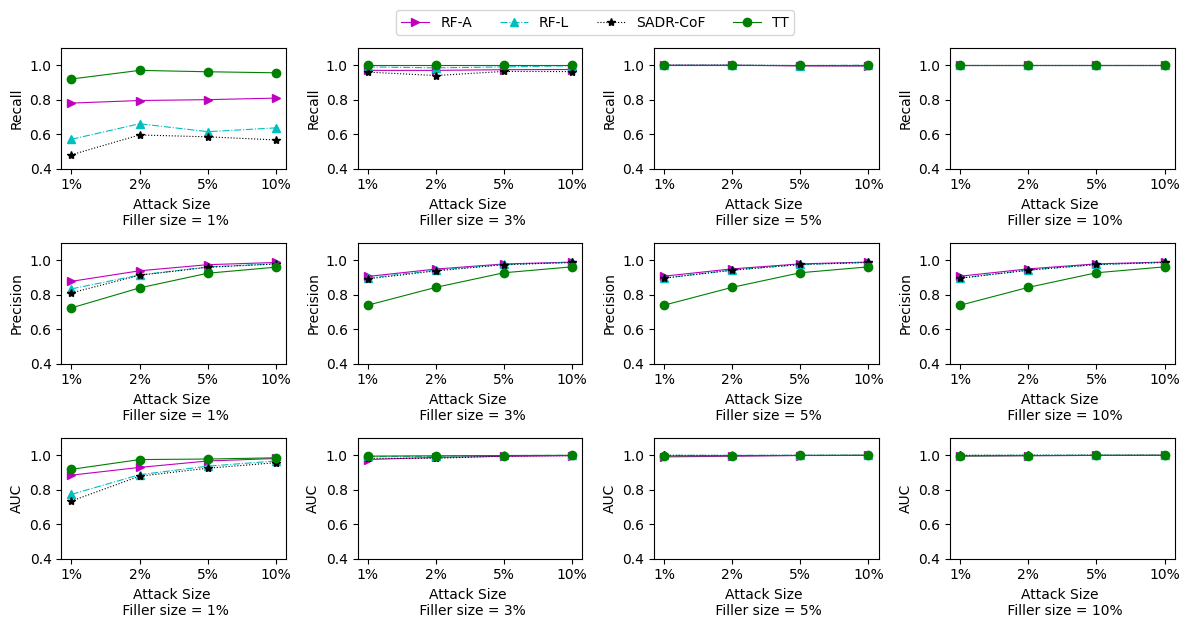

In [10]:
get_comparation_graph('average', 0.4, curve='PR')

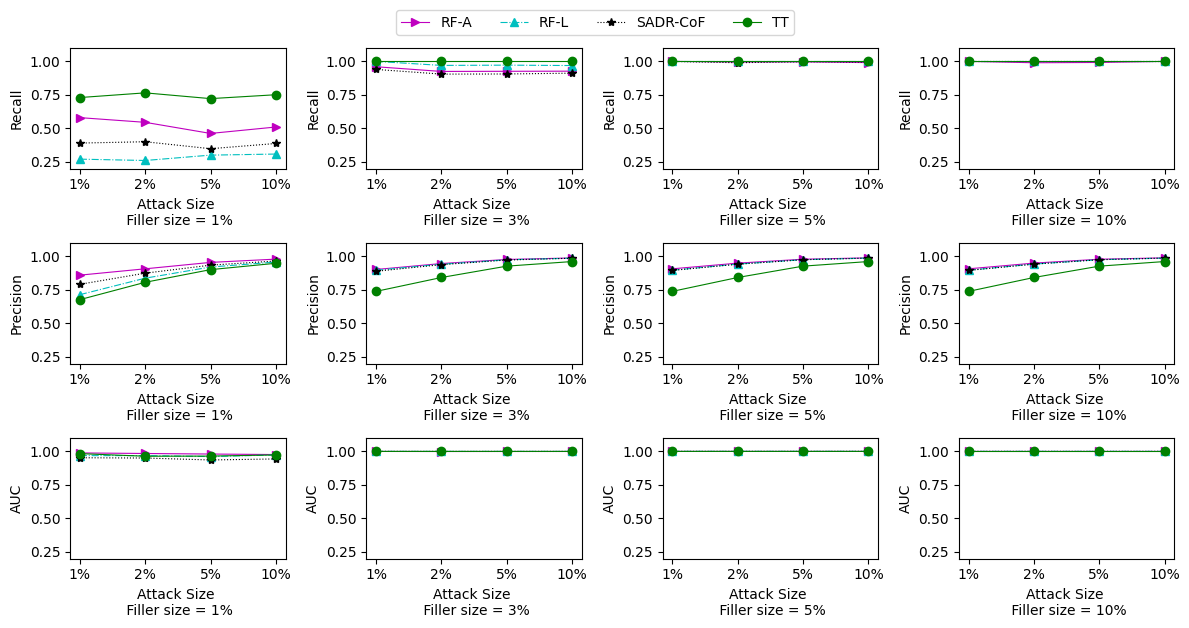

In [11]:
get_comparation_graph('bandwagon', 0.2)

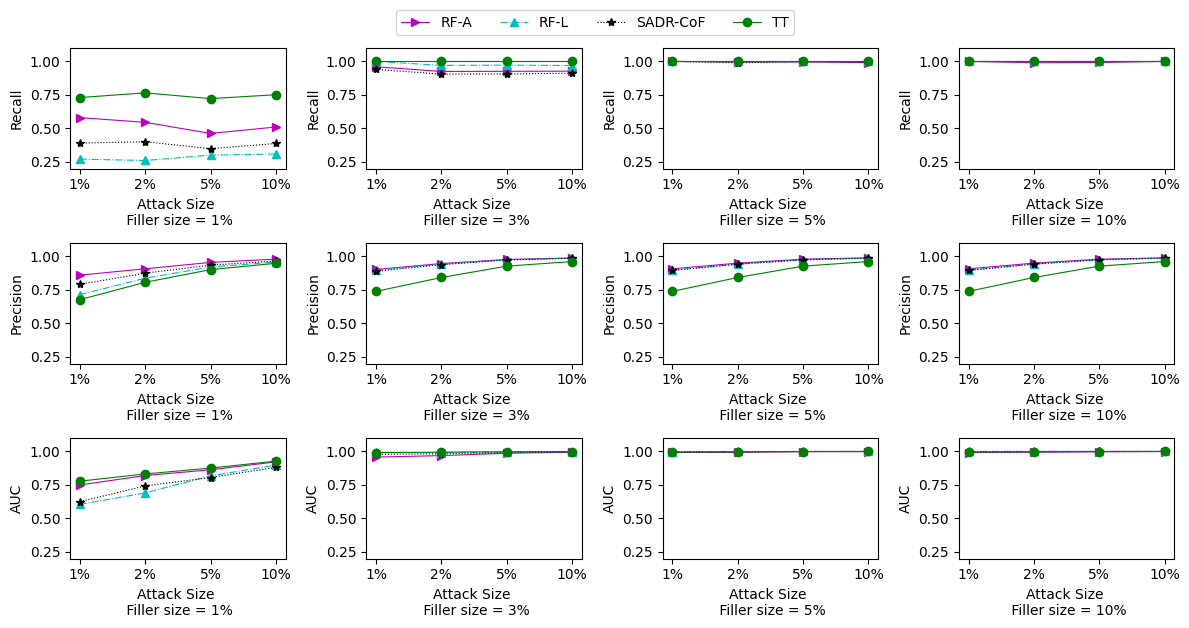

In [12]:
get_comparation_graph('bandwagon', 0.2, curve='PR')